# Basic notebook stuff
These are definitions/functions/etc that are yt/gizmo independent. All 3 are from StackOverflow, and I should cite the original source, but I've forgotten

In [1]:
import numpy as np
from itertools import chain

import scrolldown
%load_ext autoreload
%autoreload 2

class StopExecution(Exception):
    def _render_traceback_(self):
        pass


# This function lets you stop a notebook cell without causing an error or quitting the kernel
def exit():
    raise StopExecution


def flatten_list(deep_list: list[list[object]]):
    return list(chain.from_iterable(deep_list))


# This function rounds numbers to the provided number of significant figures
def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p - 1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
# Needed to set these to display animations in the notebook. You might not need them.
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150

# Regenerating the Halo Cooling paper plot
In the following few cells, we demonstrate how to obtain the plot from the cooling paper

In [3]:
import os
from rundata import RunData
from pathlib import Path
os.chdir('/home/strato/workspace/Research/dk-tools/')

rd = RunData('example/example')
opts = rd.opts
opts.outdir = Path('~/workspace/Research/dk-tools/example').expanduser()


In [4]:
from darktestrunner import DarkTestRunner
from rundata import RunData

rd = RunData('example/example')
opts = rd.opts
opts.outdir = Path('~/workspace/Research/dk-tools/halo').expanduser()
#print(opts)
exit()
dtr = DarkTestRunner(dkpath='/home/strato/workspace/Research/darkkrome')
dtr.run(opts=opts)

In [95]:
import logging

logger = logging.getLogger('DarkTestRunner')
logger.setLevel(logging.INFO)
rmrange = np.logspace(np.log10(0.07),2,25)
rMrange = np.logspace(0,3,20)
Trange = np.logspace(0,6,2)
dtr = DarkTestRunner(dkpath='/home/strato/workspace/Research/darkkrome')
dtr.run(rE=rmrange,rP=rMrange,Mhalo=1e8,z=10,xi=0.005,
        outdir=opts.outdir,notParallel=False,verbose=0,noDynDen=True)
print('Complete')

Complete


In [96]:
from rundata import RunData
from pathlib import Path
from multiprocessing import Pool
import numpy as np

examplepath = Path('halo/').glob('run*')


def processRun(runname):
    rd = RunData(runname)
    rE = rd.opts.rE
    rP = rd.opts.rP
    T = rd.opts.T
    # Since we have Dynamic Density off, we will assume that crossing the sound-crossing
    # threshold puts us back in the hydrostatic regime, so we'll stop the sim there.
    # We did this in the cooling paper too, ("Typically, the gas begins to heat or evolve
    # quasi-isothermally well before the end of the run.")
    # That means we need to mask the Jeans search
    nsound = rd.findTsoundCrossing(number=1,AcoeffScale=np.sqrt(2))
    if not nsound:
        mask=None
    else:
        mask = range(nsound[0])
    _,mind = rd.findMJeans(mask)
    minT = rd.data.Tgas[mind]
    tt = rd.getTempThresholds()
    Ta = tt.Ato
    return rE,rP,T,minT,Ta,rd.fname


def getInds(*,rP,rE,thresh=0.01):
    inds = [np.argmin(np.abs(np.log10(rP)-np.log10(rMrange))),
            np.argmin(np.abs(np.log10(rE)-np.log10(rmrange)))]
    return inds


grid = np.zeros((np.size(rMrange),np.size(rmrange)))
flag = grid.copy()
labels = [['a'] * np.size(rmrange) for _ in range(np.size(rMrange))]
numWorkers = None
with Pool(numWorkers) as pool:
    res = pool.map(processRun,examplepath)
    for r in res:
        rE,rP,T,minT,Ta,name = r
        inds = getInds(rP=rP,rE=rE)
        grid[inds[0],inds[1]] = minT/Ta
        flag[inds[0],inds[1]] = minT > T / 4
        labels[inds[0]][inds[1]] = name
#grid
#flag
print(f'min:{np.min(grid)} max:{np.max(grid)}')

min:0.004823322243346008 max:5109.39166501697


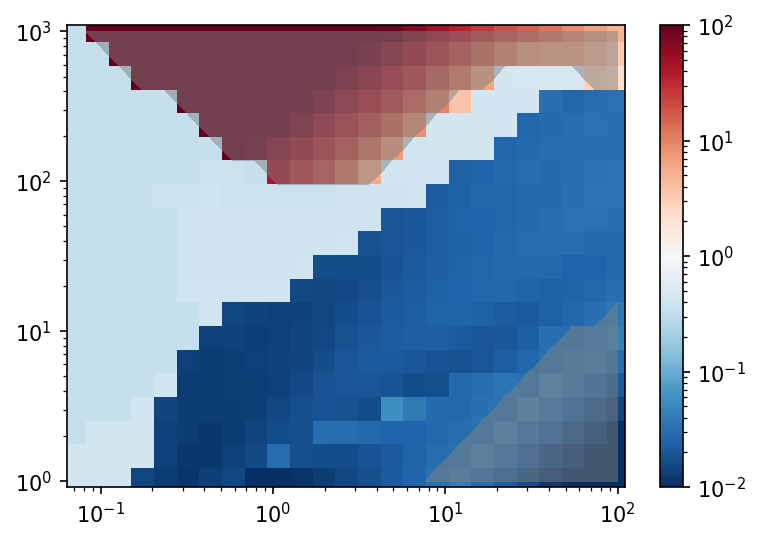

In [97]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6,4)
p = plt.pcolormesh(rmrange,rMrange,grid,cmap=mpl.colormaps['RdBu'].reversed(),norm='log')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlim(rmrange[0]/1.1,rmrange[-1]*1.1)
plt.ylim(rMrange[0]/1.1,rMrange[-1]*1.1)
plt.clim(1e-2,1e2)
plt.contourf(rmrange,rMrange,flag,1,colors=[[0,0,0,0],[0.5,0.5,0.5,0.5]])

In [208]:
opts = rd.opts
print(f'rE:{opts.rE}=={opts.de_mass/opts.m_e}\n'
      f'rP:{opts.rP}=={opts.dp_mass/opts.m_p}\n'
      f'rA:{opts.rA}=={opts.Dalpha/opts.alphaN}')
try:
    opts.checkParticleParams()
except AssertionError as ae:
    print(ae)
x = opts.de_mass/opts.m_e
y = opts.rE/1000
(x - y)/(x+y)
try:
    opts.resetParticleParams(rE=opts.rE,rP=opts.rP,rA=opts.rA)
    print('Corrected params')
except AssertionError as ae:
    print(ae)

rE:8.858667904100823==0.01
rP:11.28837891684689==1.0
rA:1.0==1.0
de_mass/m_e(0.01) and rE(8.858667904100823) mismatch
Corrected params


run_rE0.0774263682681127_rp1000.0_ra1_xi0.005_t11458288_z10_e1.000.zip
ntot      3.185285e-04
Tgas      7.638859e+06
E         3.170831e-37
Hm        3.170831e-37
QE        6.835389e-08
QHm       1.007045e-17
H         3.170831e-37
HE        3.170831e-37
H2        3.170831e-37
QH        1.009999e+00
QH2       3.283232e-07
Hp        3.170831e-37
HEp       3.170831e-37
H2p       3.170831e-37
QHp       6.835389e-08
QH2p      7.793099e-27
QH3p      1.380629e-32
HEpp      3.170831e-37
tff       2.641412e+15
tsound    5.044732e+15
tc        1.104661e+21
Mjeans    1.929476e+41
pdv       1.000000e+00
time      1.494209e+16
Name: 0, dtype: float64
RunOpts(g_to_KeV=5.609588649834766e+29, KeV_to_K=11604505.0, k=1.381e-16, G=6.6743e-08, m_p=1.67262158e-24, m_e=9.10938188e-28, M_sun=1.9891e+33, alphaN=0.0072973525664, delta=178, h=0.677, Mpcincm=3.085678e+24, Myrinsec=31536000000000.0, Dalpha=0.0072973525664, dp_mass=1.6726215800000001e-21, de_mass=7.053063561357528e-29, rA=1.0, rP=1000.0, rE=0.077

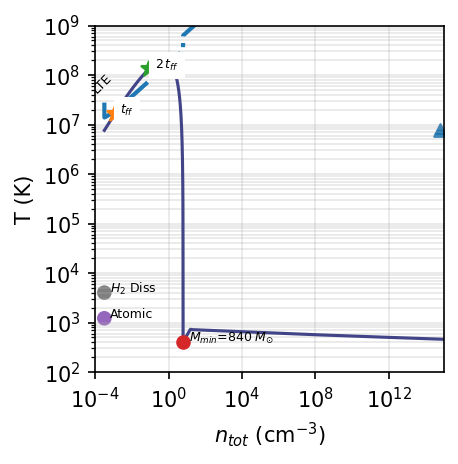

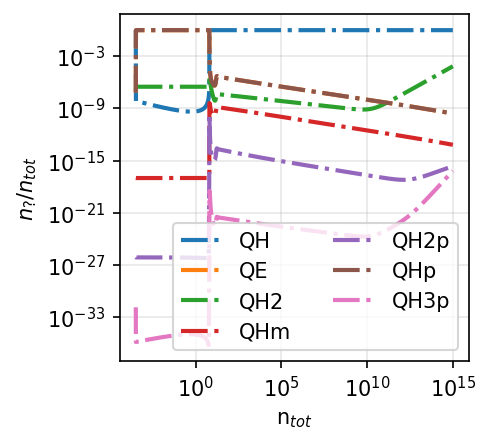

In [89]:
rP = 1000
rE = .1
inds = getInds(rP=rP,rE=rE)
name=labels[inds[0]][inds[1]]
print(name)
rd = RunData(Path('halo',name))
ax = rd.plot()
ax.figure.set_size_inches(3,3)
ax,_ = rd.plotNumberDensities()
ax.figure.set_size_inches(3,3)
print(rd.data.loc[0,:])
print(rd.opts)

Saving as file set run_rE0.11288378916846889_rp11.28837891684689_ra1.0_xi0.005_t129345_z10_e1.000.run


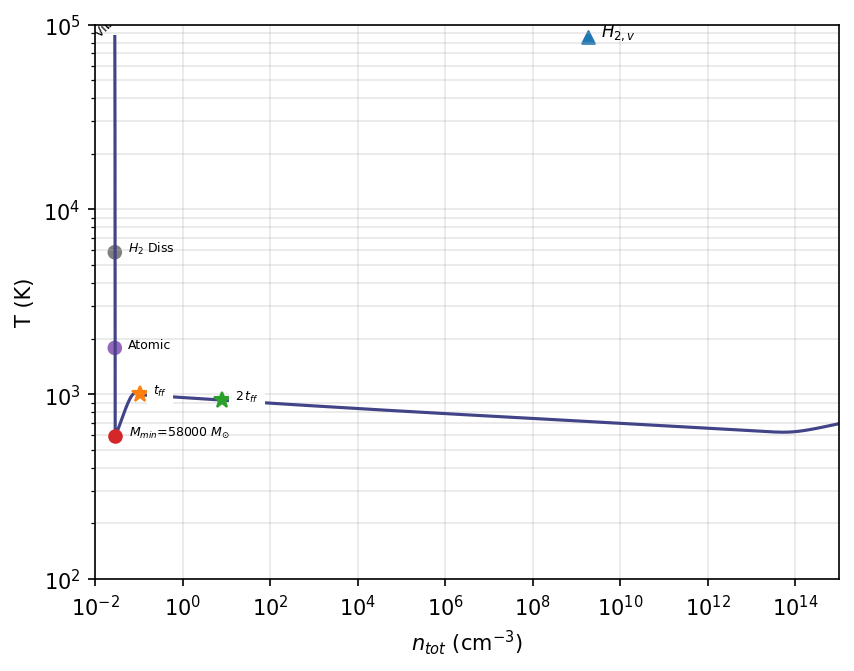

In [80]:
opts2 = rd.opts
dtr = DarkTestRunner(dkpath='/home/strato/workspace/Research/darkkrome')
nr=dtr.run(rE=opts2.rE,rP=opts2.rP,rA=opts2.rA,xi=opts2.xi,epsilon=opts2.epsilon,
           Mhalo=opts2.Mhalo,z=opts2.zred,outdir=opts2.outdir,noDynDen=True)
rd=RunData(Path('halo',nr[0]))
rd.plot();

RunOpts(g_to_KeV=5.609588649834766e+29, KeV_to_K=11604505.0, k=1.381e-16, G=6.6743e-08, m_p=1.67262158e-24, m_e=9.10938188e-28, M_sun=1.9891e+33, alphaN=0.0072973525664, delta=178, h=0.677, Mpcincm=3.085678e+24, Myrinsec=31536000000000.0, Dalpha=0.0072973525664, dp_mass=1.8881186179535135e-23, de_mass=8.069698888655363e-27, rA=1.0, rP=11.28837891684689, rE=8.858667904100823, omega_m=0.3106938465600038, omega_b=0.04897573577059274, epsilon=1.0, xi=0.005, de_massG=0.0045267691293385355, dp_massG=10.591568768813735, m=4526.779298995521, M=10.588499424002382, krome_redshift=10.0, zred=10.0, start_density=10.0, end_density=10000000000.0, T=129345.50532060317, Mhalo=100000000.0, Mgas=84236657.30337079, noDynDen=True, verbose=0, dryrun=False, notParallel=False, force=False, overwrite=False, outdir='/home/strato/workspace/Research/dk-tools/halo', dkcmd="['./darkkrome', '-r', '--temp', '129345.50532060317', '--zred', '10.0', '--epsilon', '1.0', '-D']", skipchecks=False, initialized=True)

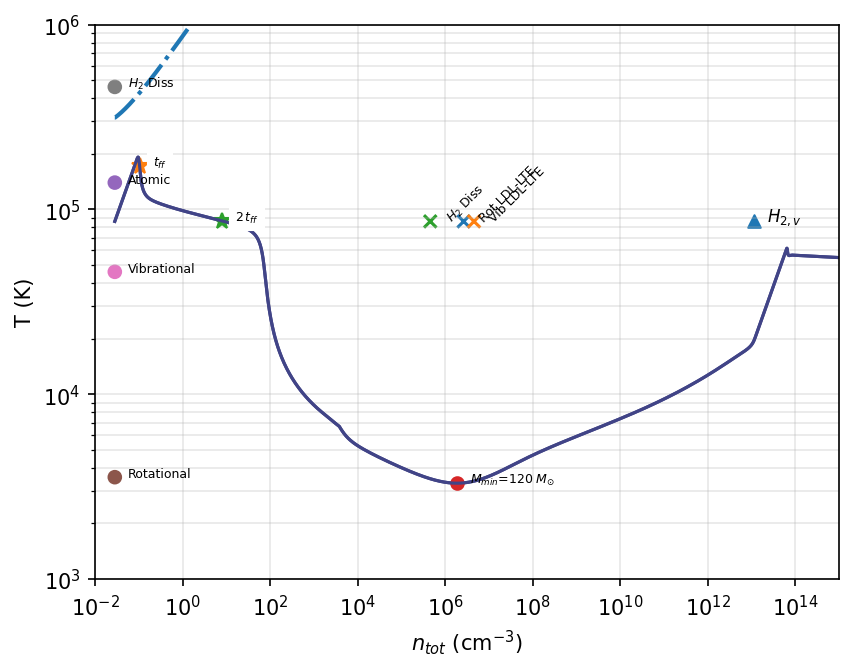

In [58]:
rd=RunData(Path('halo',nr))
ax=rd.plot()
rd1=RunData(Path('halo',nr.replace('xi0.01','xi0.005')))
rd1.plotTrajectory(ax=ax)
rd1.opts

In [17]:
from Virial import Virial
v = Virial(M_gev=1,z=10)
print(v.Tv(1e6))
v

567.0006949362222


Virial(G=6.6743e-08, KB_CGS=1.38065e-16, KB_EV=8.61733e-05, C_CGS=29979245800, MSOL=1.988e+33, GRAM_TO_GEV=5.60969e+23, SPHERICAL_PROFILE=0.6, OmegaM=0.3106938465600038, H0_base=67.7, H0=2.19400806e-18, OmegaB=0.04897573577059274, OmegaR=5.428414959559617e-05, OmegaDM=0.2617181107894111, Omega=0.3106938465600038, dens_prof=0.6, h=0.677, OmegaL=0.6894, epsilon=1, f=0.8423665730337079, delta=178, mu=1, gamma=1.6666666666666667, M_cgs=1.7826296996803744e-24, M_gev=1, z=10, rho=6.372588083789258e-25)

In [63]:
from RunData import RunFlags
print(RunFlags.printFlagDescriptions())
rd.flags.long_description()

<generator object RunFlags.printFlagDescriptions.<locals>.<genexpr> at 0x7efdf11a31b0>
None
equil: none
molCool: mol cooling sometimes dominates
rovibCool: vib only
coolType: nan
effCool: min temp before 10 Gyr
subsolar: Mjmin > 1 Msol
highn: ntot(end)>1e9 (ignore equil flag)
hasIso: isobaric evolution disabled
isoThresh: temperature crossed isobaric threshold
smallMass: m<<M
cmb:spectral distortions acceptable
threebody: 2-body interaction timescale dominates
radop: radiative transitions are neglible
protMol: p-H2 cooling dominated H-H2 cooling
h3p: H3p is ignorable
h2opacity: transparent H2 lines
nonhydro: SPH model valid
